In [1]:
import pandas as pd
import random
from time import time

In [2]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
import matplotlib.pyplot as plt

In [5]:
#Read document data
col_names=['docID', 'wordID', 'count']
df_dataText=pd.read_csv('NewYorkTimes/docword.nytimes/docword.nytimes.txt', header=None, delim_whitespace=True, skiprows=3,
                        names=col_names)
#check the first 5 rows of data
df_dataText.head()


,docID,wordID,count
0,1,413,1
1,1,534,1
2,1,2340,1
3,1,2806,1
4,1,3059,1


In [6]:
#Read vocabulary data
col_Vnames=['vocab_word']
df_dataVocab=pd.read_csv('NewYorkTimes/vocab.nytimes.txt',header=None, delim_whitespace=True,names=col_Vnames)
df_dataVocab.head()

,vocab_word
0,aah
1,aahed
2,aaron
3,aback
4,abacus


In [7]:
#Add n(id number) column to vocab data
df_dataVocab['n']=df_dataVocab.index+1
df_dataVocab.head()

,vocab_word,n
0,aah,1
1,aahed,2
2,aaron,3
3,aback,4
4,abacus,5


In [8]:
#function to collect words for each document
def get_docWords(docId):
    c1=df_dataText['docID']==docId
    c2=df_dataText['count']>=3#count greater than 3
    df_filtered=df_dataText[(c1)&(c2)][['wordID','count']].reset_index(drop=True)
    df_filtered=df_filtered.merge(df_dataVocab,left_on=['wordID'], right_on=['n'],how='inner')[['vocab_word','count']]    
    return df_filtered

In [9]:
#Lemmatize each word
def lemmatize_words(lst_tag_words):    
    lst_words_lemmatized=[]
    for w,t in lst_tag_words:
        tg=t[0].lower()
        if tg not in ['a', 'r', 'n', 'v']:
            lst_words_lemmatized.append(w)
        else:
            lst_words_lemmatized.append(obj_lemmatizer.lemmatize(w,tg))
    return lst_words_lemmatized

In [10]:
#Create cleaned text dataset in order to feed into clustering algorithms
obj_lemmatizer=WordNetLemmatizer()
train_corpus=[]
for docId in range(1,5001):
    isSuccess=True
    #get words in a document
    df_doc_words=get_docWords(docId)
    try:
        #Assign POS tag for each word, Lemmatizer requires correct POS tag to accurately lemmatize words
        df_doc_words['pos_tag']= pos_tag(df_doc_words['vocab_word'])
        #Group different inflections of the same word.
        df_doc_words['lemmatized_words']=lemmatize_words(df_doc_words['pos_tag'].tolist())
    except:
        isSuccess=False
    if isSuccess:
        txt_sentnc=''
        for i,row in df_doc_words.iterrows():
            if row['lemmatized_words']!='':
                w=row['lemmatized_words']
                if w[:4]!='zzz_':
                    txt_sentnc+=' '+(w+' ')*row['count']    
        txt_sentnc=txt_sentnc.strip()
        if txt_sentnc!='':
            txt_sentnc=txt_sentnc.split()
            random.shuffle(txt_sentnc)
            txt_sentnc=' '.join(txt_sentnc)
            train_corpus.append(txt_sentnc)

In [11]:
#Print first five sentences
train_corpus[0:5]

['rank win team team scored scored play point scored half game half player play point point play scored game team team win scored rank rank night play rank play win player game night team game night point half player half play',
 'number paper front issue error number issue error issue number issue issue front number paper error paper number paper number number issue issue issue front',
 'security celebration terrorism crowd light friend friend firework friend crowd leave terrorism celebration celebration security midnight leave celebration light crowd firework leave midnight security midnight crowd terrorism light crowd firework',
 'commercial cancel system passenger air cancel system air air thousand traffic air control traffic flight aviation air thousand control flight flight traffic control air midnight thousand commercial commercial system passenger midnight air commercial traffic aviation flight passenger flight midnight passenger traffic air cancel aviation midnight',
 'televis

In [12]:
#print no. of elements in train_corpus
len(train_corpus)

4915

In [26]:
#Plot topics found with top number of words in it
def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(3, 6, figsize=(30, 20), sharex=True)
    axes = axes.flatten()
    for topc_indx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topc_indx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topc_indx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle("Topics found with LDA model", fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [14]:
#########################   Vectorization  #########################

In [15]:
#Create vector of words for each document using CountVectorizer
#max_df=0.95; Ignore terms that appear in more than 95% of the documents
#min_df=2; Ignore terms that appear in less than 2 document
time_start=time()
num_features = 5000
obj_CountVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features)
train_corpus_vectorized = obj_CountVectorizer.fit_transform(train_corpus)
time_taken=time()-time_start
print('Time(seconds) taken to vectorize text data:',time_taken)

Time(seconds) taken to vectorize text data: 0.528977632522583


In [16]:
######################### Clustering Latent Dirichlet Allocation #########################

In [17]:
#Latent Dirichlet Allocation clustering model
time_start=time()
num_components = 18
objLDA_model = LatentDirichletAllocation(n_components=num_components, max_iter=5, learning_method="online",
    learning_offset=50.0, random_state=0)
objLDA_model.fit(train_corpus_vectorized)
time_taken=time()-time_start
print('Time(seconds) taken to train LDA model:',time_taken)

Time(seconds) taken to train LDA model: 4.977417707443237


In [18]:
######################### Evaluate Results #########################

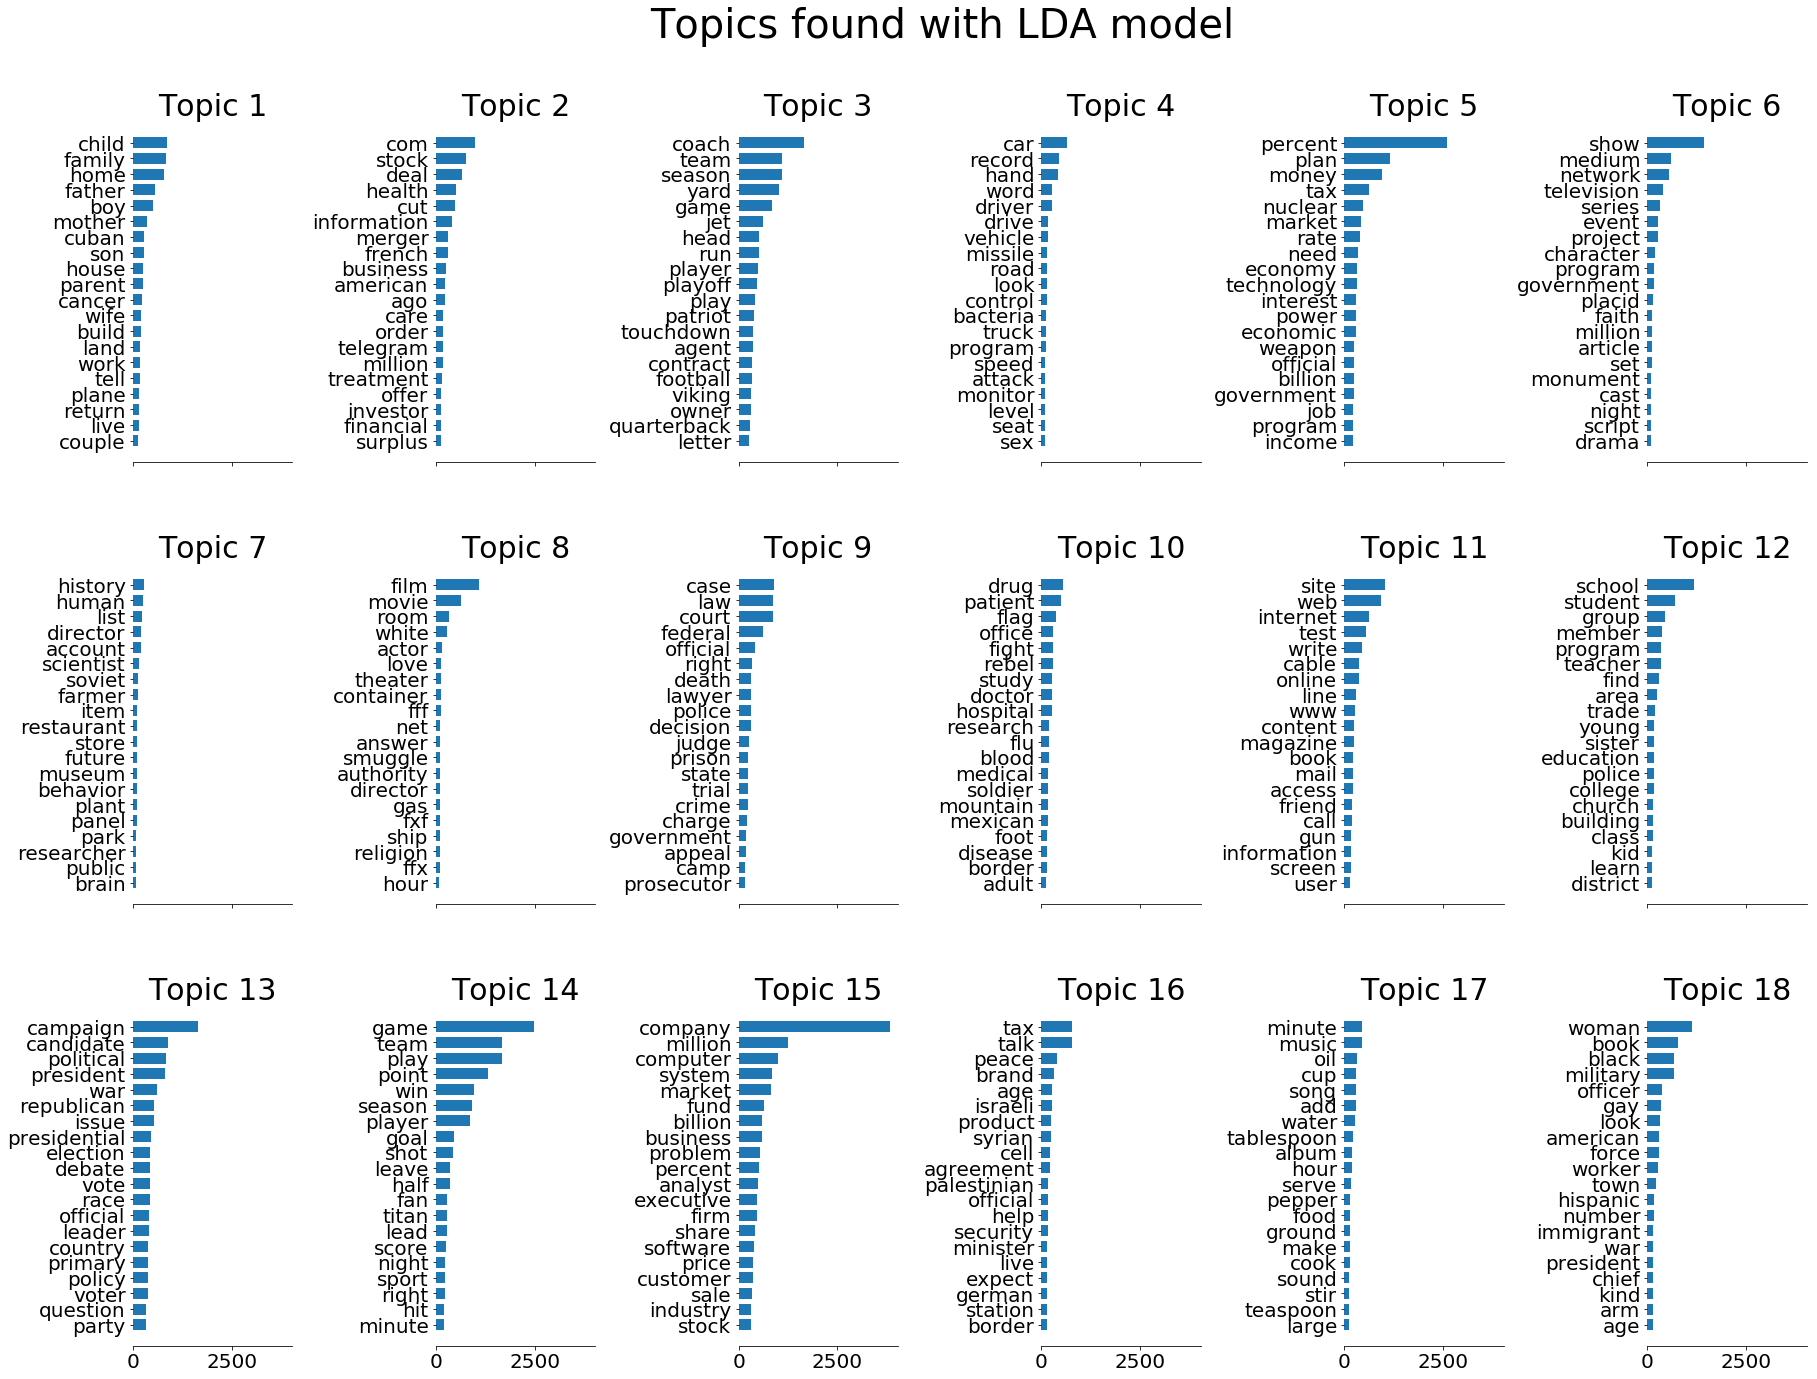

In [27]:
#Plot topics found with top number of words in it
num_top_words=20
feature_names = obj_CountVectorizer.get_feature_names()
plot_top_words(objLDA_model, feature_names, num_top_words)